## Create a bootstrapped t_test function and show it off using the iris data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.weightstats as smsw
from scipy import stats
from statsmodels.stats.multitest import multipletests

#### Load in the iris data set and plot it a bit

In [2]:
ir_df = sns.load_dataset("iris")
#ir_df.head(), ir_df.info()
ir_df["species"] = ir_df["species"].astype('category')
ir_df["species"].unique()

[setosa, versicolor, virginica]
Categories (3, object): [setosa, versicolor, virginica]

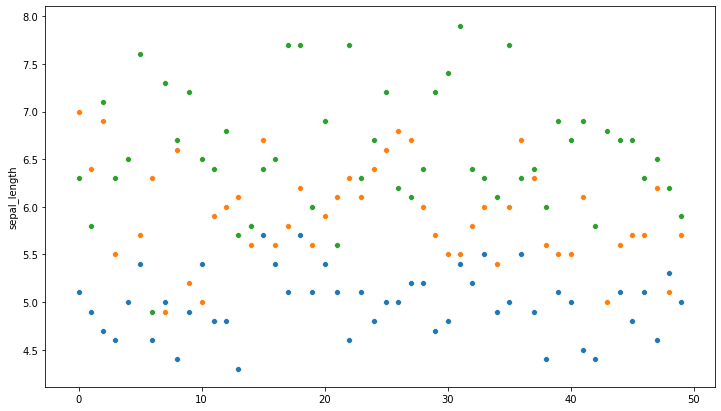

In [3]:
_ = plt.figure(figsize=(12,7))
group_1 = ir_df[ir_df["species"]=="setosa"].sepal_length
group_2 = ir_df[ir_df["species"]=="versicolor"].sepal_length
group_3 = ir_df[ir_df["species"]=="virginica"].sepal_length
_ = sns.scatterplot(range(0,len(group_1)), group_1)
_ = sns.scatterplot(range(0,len(group_2)), group_2)
_ = sns.scatterplot(range(0,len(group_3)), group_3)

#### Define a function which generates many bootstrapped p-values from an independent t-test

In [4]:
## define a function which generates many bootstrapped p-values from an independent t-test
def boot_independent_t_test(data: pd.DataFrame, feature: str, grouping_var: str, 
                            grouping_grp1: str, grouping_grp2: str, size = 10) :    
    # select the 'feature' and 'grouping_var' columns and remove row if any nan present
    data = data.copy()
    data = data[[feature, grouping_var]] 
    _    = data.dropna(axis = 0, how = 'any', inplace = True)

    # New dataframes
    group1 = data.loc[data[grouping_var] == grouping_grp1]
    _ = group1.reset_index(inplace = True)
    group2 = data.loc[data[grouping_var] == grouping_grp2]
    _ = group2.reset_index(inplace = True)

    # Check assumption: homogeneity of variances
    (levene, p_value) = stats.levene(group1[feature], group2[feature])
    
    # Initialize empty numpy array for the bootstrapping
    bs_replicates = np.empty(size)

    if p_value < 0.05 :
        # YES: Run t-test using statsmodels - unequal variance
        group_variance = "Unequal"
        for i in range(size):
            bs_sample_gr_1 = np.random.choice(group1[feature], len(group1[feature]), replace=True)
            bs_sample_gr_2 = np.random.choice(group2[feature], len(group2[feature]), replace=True)
            bs_replicates[i] = smsw.ttest_ind(bs_sample_gr_1,
                                              bs_sample_gr_2, 
                                              usevar = 'unequal')[1]                  
    else :
        # NO: Run t-test using statsmodels - equal variances
        group_variance = "Equal"
        for i in range(size):
            bs_sample_gr_1 = np.random.choice(group1[feature], len(group1[feature]), replace=True)
            bs_sample_gr_2 = np.random.choice(group2[feature], len(group2[feature]), replace=True)
            bs_replicates[i] = smsw.ttest_ind(bs_sample_gr_1,
                                              bs_sample_gr_2, 
                                              usevar = 'pooled')[1]     
    return bs_replicates

#### Plot all the p_values from a single feature

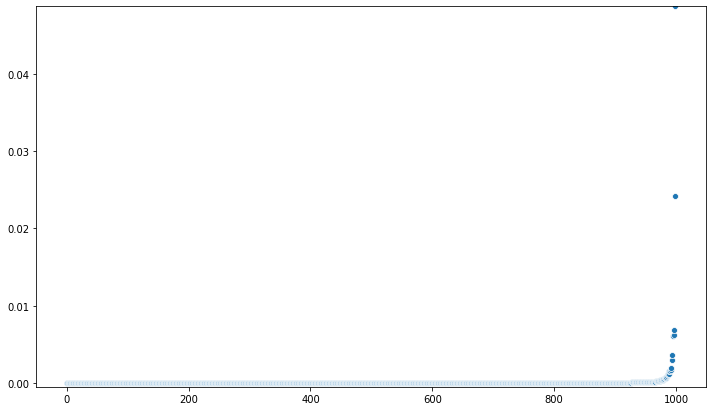

In [19]:
_ = plt.figure(figsize=(12,7))
bs_replicates_sp_l = boot_independent_t_test(data=ir_df, feature="sepal_length", grouping_var="species", 
                            grouping_grp1="versicolor", grouping_grp2="virginica", size = 1000)
_ = sns.scatterplot(range(0,len(bs_replicates_sp_l)), np.sort(bs_replicates_sp_l))
_ = plt.ylim(min(bs_replicates_sp_l)-0.0005, max(bs_replicates_sp_l))

#### Plot all the p_values from a list of features

sepal_length
sepal_width
petal_length
petal_width


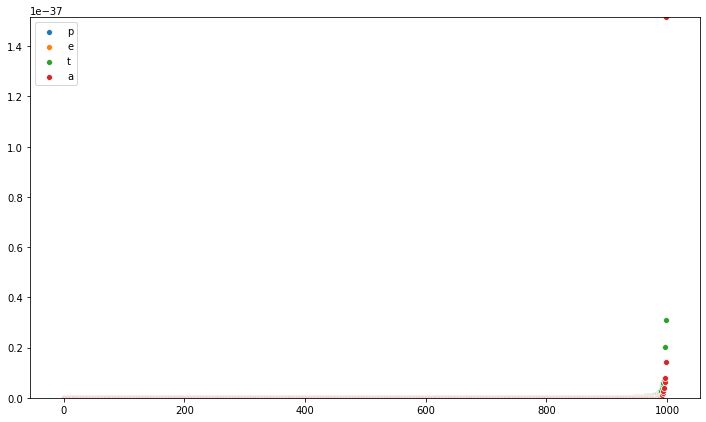

In [22]:
size = 1000
_ = plt.figure(figsize=(12,7))
feat_list = ir_df.drop("species", axis=1).columns.values
for i in range(0,len(feat_list)):
    leg_name = feat_list[i]
    print(leg_name)
    bs_replicates = boot_independent_t_test(data=ir_df, feature=feat_list[i], grouping_var="species", 
                            grouping_grp1="setosa", grouping_grp2="versicolor", size = size)
    _ = sns.scatterplot(range(0,len(bs_replicates)), np.sort(bs_replicates))
    _ = plt.ylim(min(bs_replicates), max(bs_replicates))
    _ = plt.legend(leg_name, loc='upper left')

### Using the p-values from the bootstrapped t_test correct using Benjamini/Hochberg (non-negative) using "multipletests" from statsmodels and compare to ideal p-values

In [23]:
pvals = bs_replicates_sp_l # p-values from looking at sepal-length between versicolor and virginica
multi_test_method = "fdr_bh"
reject, pvals_corrected, alphacSidak, alphacBonf =\
multipletests(pvals, alpha=0.05, method=multi_test_method,
              is_sorted=False, returnsorted=False)

#### Define and plot the comparison

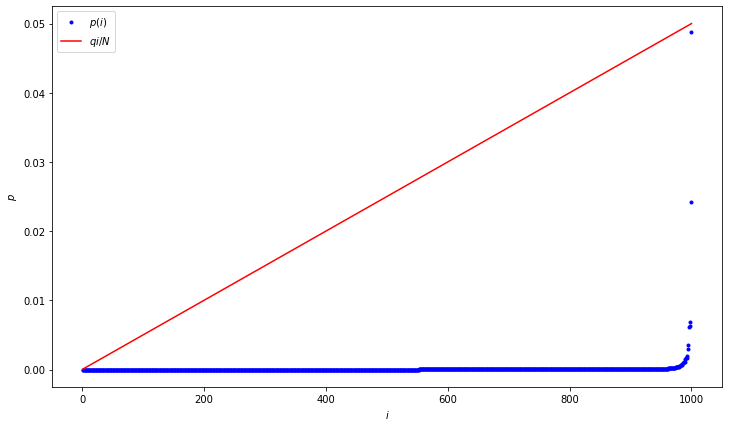

In [29]:
rang_len = 1000
_ = plt.figure(figsize=(12,7))
N = len(bs_replicates_sp_l)
q = 0.05
i = np.arange(1, N+1)
# define ideal p-value
ideal_p_val = q * i / N
# sort the corrected p-values
pvals_corrected_s = np.sort(pvals_corrected)
plt.plot(i[:rang_len], pvals_corrected_s[:rang_len], 'b.', label='$p(i)$')
plt.plot(i[:rang_len], ideal_p_val[:rang_len], 'r', label='$q i / N$')
_ = plt.xlabel('$i$')
_ = plt.ylabel('$p$')
_ = plt.legend()